# Initialization and dataset preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
df = pd.read_csv('daily_data_2024-10-22.csv')
df['dates'] = pd.to_datetime(df['dates'])

In [3]:
df

,dates,Norway,Algeria,Russia,Azerbaijan,Libya,UK net flows,LNG,EU total,Nord Stream,Ukraine Gas Transit,"Yamal (BY,PL)",Turkstream,Russia (Sudzha)
0,2018-01-08,263.4,76.1,570.2,0.0,13.8,45.4,114.8,1083.8,174.4,266.1,110.1,NaN,NaN
1,2018-02-08,262.6,74.8,578.5,0.0,12.8,47.0,122.9,1098.6,170.6,277.5,110.2,NaN,NaN
2,2018-03-08,251.0,74.0,565.5,0.0,11.4,39.5,124.8,1066.2,170.3,263.8,110.3,NaN,NaN
3,2018-04-08,257.1,71.0,561.5,0.0,12.3,35.6,93.7,1031.1,170.6,258.8,110.3,NaN,NaN
4,2018-05-08,253.9,69.7,565.7,0.0,11.7,33.7,83.0,1017.8,170.1,263.9,110.4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268,2024-10-16,259.0,93.0,83.0,35.0,5.0,27.0,309.0,811.0,NaN,41.0,NaN,43.0,45
2269,2024-10-17,243.0,92.0,83.0,35.0,2.0,23.0,316.0,795.0,NaN,39.0,NaN,44.0,46
2270,2024-10-18,235.0,92.0,84.0,37.0,2.0,22.0,314.0,786.0,NaN,39.0,NaN,45.0,47
2271,2024-10-19,257.0,83.0,89.0,37.0,2.0,20.0,261.0,749.0,NaN,39.0,NaN,50.0,46


Using ARIMA model to predict 
 - Make sure series are stationarry using DF test
 - If not Try first differencing
  - - Retest using ADF
  - - If not Normalizing
  - - If yes Plot ACF and PACF to get the p,q
  - - Fit the model and predict
  - - If uncertain about p,q try different models (p,q) and compare their AIC, BIC, and predict using the one with the best values



# Russia Timeseries

## Russia Dickey Fueller Test

In [4]:
# Perform the ADF test
result = adfuller(df['Russia'])

# Extract and print the test statistic and p-value
test_statistic = result[0]
p_value = result[1]

print(f'ADF Test Statistic: {test_statistic}')
print(f'p-value: {p_value}')

# Print the critical values
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Test Statistic: -0.9753066664846265
p-value: 0.7621637587344547
Critical Value (1%): -3.433255799449242
Critical Value (5%): -2.862823704909085
Critical Value (10%): -2.56745337629031


### Given the timesteries are non stationary, we perform ADF test after first differencing

In [5]:
# Perform the ADF test after first differencing
result = adfuller(df['Russia'].diff().dropna())

# Extract and print the test statistic and p-value
test_statistic = result[0]
p_value = result[1]

print(f'ADF Test Statistic: {test_statistic}')
print(f'p-value: {p_value}')

# Print the critical values
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Test Statistic: -9.64144064378659
p-value: 1.5171162262520145e-16
Critical Value (1%): -3.433267467097435
Critical Value (5%): -2.862828856845257
Critical Value (10%): -2.567456119332679


First differencing yielded stationary results (p value below 5%)

## ACF, PACF for Russia

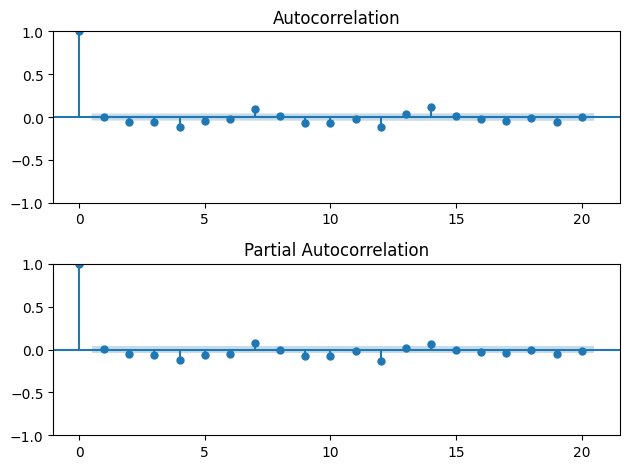

In [6]:
f, ax = plt.subplots(nrows=2, ncols=1)

plot_acf(df['Russia'].diff().dropna(),lags=20, ax=ax[0])
plot_pacf(df['Russia'].diff().dropna(),lags=20, ax=ax[1], method='ols')

plt.tight_layout()
plt.show()

Given the ACF and PACF cut off after 1 lag, we have p=q=1 after first differencing d=1

## Russia ARIMA(1,1,1) predictions

Mean Squared Error: 28.510314865782096


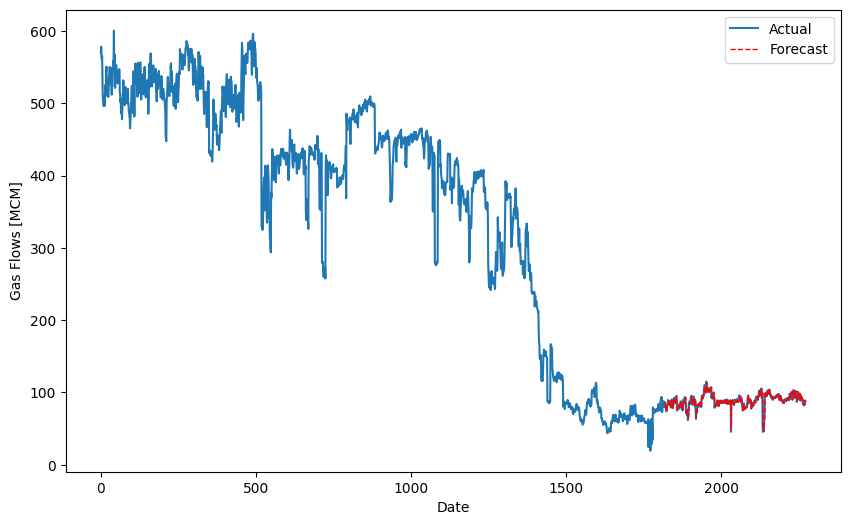

In [7]:
#Setting train and test data size at 80% and 20% respectively, data is sorted by date 
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]
value= 'Russia'


# Fitting ARIMA model
predictions = []
history = [x for x in train[value]]

for t in range(len(test)):
    model = ARIMA(history, order=(1, 1, 1))

    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[value].iloc[t]
    history.append(obs)

test['predictions'] = predictions

# Evaluating the model
mse = mean_squared_error(test[value], test['predictions'])
print(f'Mean Squared Error: {mse}')

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(df[value],label='Actual')
plt.plot(test['predictions'], label='Forecast', color='red', linestyle='--', linewidth=1)
plt.ylabel('Gas Flows [MCM]')
plt.xlabel('Date')
plt.legend()
plt.show()

In [8]:
print('The R^2 score for Russia flows time series is', r2_score(test['Russia'],test['predictions']))

The R^2 score for Russia flows time series is 0.6762587119769835


# Libya Timeseries

## ADF test for Libya

In [9]:
# Perform the ADF test
result = adfuller(df['Libya'])

# Extract and print the test statistic and p-value
test_statistic = result[0]
p_value = result[1]

print(f'ADF Test Statistic: {test_statistic}')
print(f'p-value: {p_value}')

# Print the critical values
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Test Statistic: -2.2238174524667462
p-value: 0.19771492656084866
Critical Value (1%): -3.4332661660670696
Critical Value (5%): -2.8628282823666926
Critical Value (10%): -2.567455813463227


### Given the timesteries are non stationary (p>5%), we perform ADF test after first differencing

In [10]:
# Perform the ADF test after first differencing
result = adfuller(df['Libya'].diff().dropna())

# Extract and print the test statistic and p-value
test_statistic = result[0]
p_value = result[1]

print(f'ADF Test Statistic: {test_statistic}')
print(f'p-value: {p_value}')

# Print the critical values
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Test Statistic: -13.237418030574435
p-value: 9.31770837628117e-25
Critical Value (1%): -3.433267467097435
Critical Value (5%): -2.862828856845257
Critical Value (10%): -2.567456119332679


## ACF, PACF for Libya

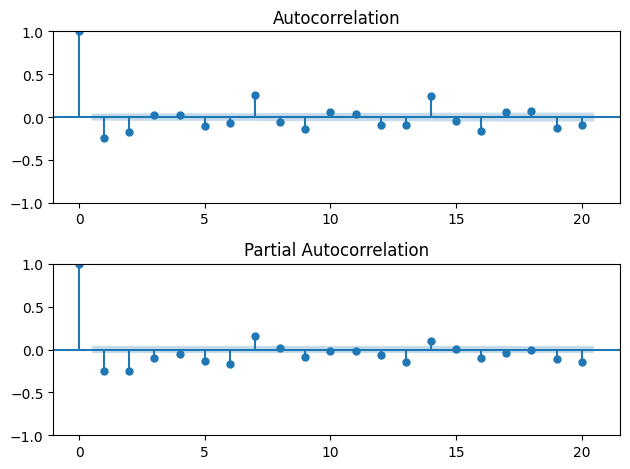

In [11]:
f, ax = plt.subplots(nrows=2, ncols=1)
plot_acf(df['Libya'].diff().dropna(),lags=20, ax=ax[0])
plot_pacf(df['Libya'].diff().dropna(),lags=20, ax=ax[1], method='ols')

plt.tight_layout()
plt.show()

Given the ACF and PACF cut off after 1 lag, we have p=q=1 after first differencing d=1

## Libya ARIMA (1,1,1)

Mean Squared Error: 2.336856039741527


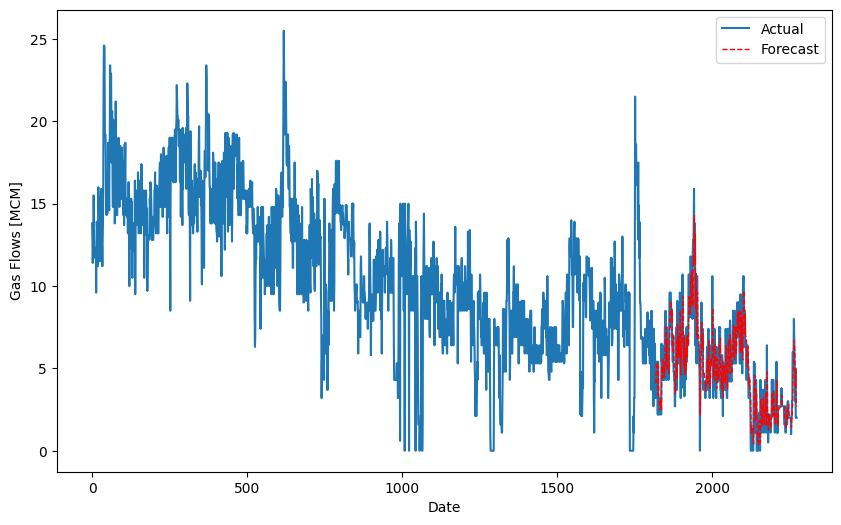

In [12]:
# Setting train and test data size at 80% and 20% respectively
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]
value= 'Libya'


# Fitting ARIMA model
predictions = []
history = [x for x in train[value]]

for t in range(len(test)):
    model = ARIMA(history, order=(1, 1, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[value].iloc[t]
    history.append(obs)

test['predictions'] = predictions

# Evaluating the model
mse = mean_squared_error(test[value], test['predictions'])
print(f'Mean Squared Error: {mse}')

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(df[value],label='Actual')
plt.plot(test['predictions'], label='Forecast', color='red', linestyle='--', linewidth=1)
plt.ylabel('Gas Flows [MCM]')
plt.xlabel('Date')
plt.legend()
plt.show()

In [13]:
print('The R^2 score for Libya flows time series is', r2_score(test['Libya'],test['predictions']))

The R^2 score for Libya flows time series is 0.6884741490500088


# Norway Timeseries

## ADF test for Norway

In [14]:
# Perform the ADF test
result = adfuller(df['Norway'])

# Extract and print the test statistic and p-value
test_statistic = result[0]
p_value = result[1]

print(f'ADF Test Statistic: {test_statistic}')
print(f'p-value: {p_value}')

# Print the critical values
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Test Statistic: -6.2186212958486795
p-value: 5.290072496189308e-08
Critical Value (1%): -3.4332391099897013
Critical Value (5%): -2.8628163355201113
Critical Value (10%): -2.5674494526166383


### Given the timesteries are stationary (p>5%)

## ACF, PACF for Norway

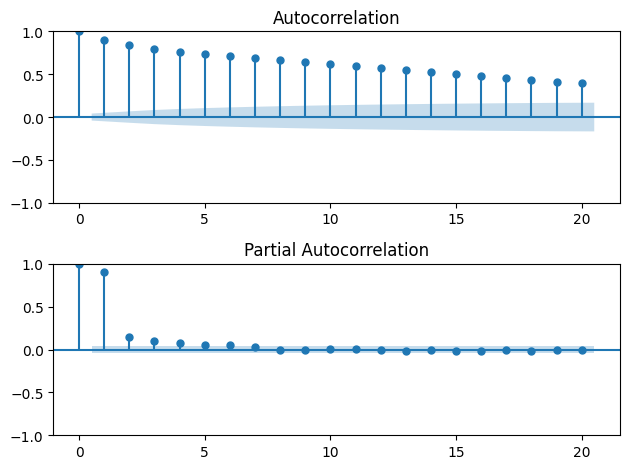

In [15]:
f, ax = plt.subplots(nrows=2, ncols=1)
plot_acf(df['Norway'],lags=20, ax=ax[0])
plot_pacf(df['Norway'],lags=20, ax=ax[1], method='ols')

plt.tight_layout()
plt.show()

Given the timeseries are stationary, the ACF does not cut off, and PACF cut off after 1 lag, we have p=1 q= 0 d=0

## Norway ARIMA (1,0,0), so AR(1)

Mean Squared Error: 178.266159021205


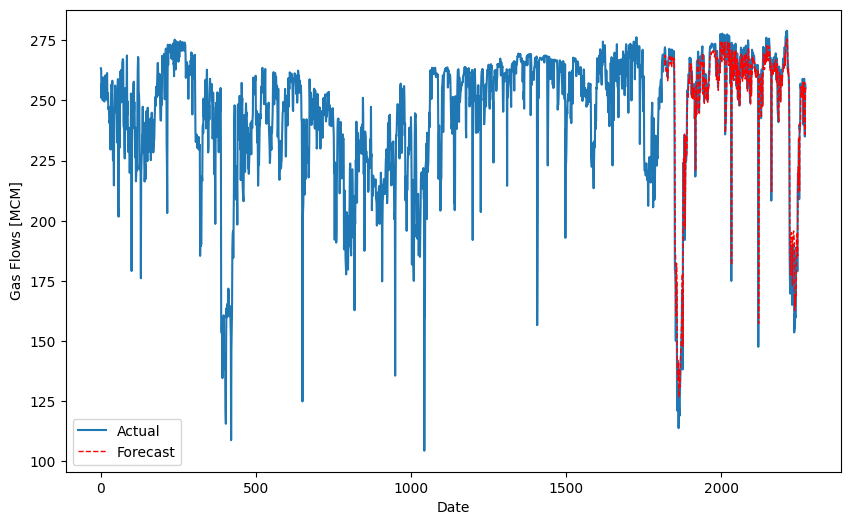

In [16]:
# Setting train and test data size at 80% and 20% respectively
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]
value= 'Norway'


# Fitting ARIMA model
predictions = []
history = [x for x in train[value]]

for t in range(len(test)):
    model = ARIMA(history, order=(1, 0, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[value].iloc[t]
    history.append(obs)

test['predictions'] = predictions

# Evaluating the model
mse = mean_squared_error(test[value], test['predictions'])
print(f'Mean Squared Error: {mse}')

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(df[value],label='Actual')
plt.plot(test['predictions'], label='Forecast', color='red', linestyle='--', linewidth=1)
plt.ylabel('Gas Flows [MCM]')
plt.xlabel('Date')
plt.legend()
plt.show()

In [17]:
print('The R^2 score for Norway flows time series is', r2_score(test['Norway'],test['predictions']))

The R^2 score for Norway flows time series is 0.8588316795776408


# Azerbaijan Timeseries

## ADF test for Azerbaijan

In [18]:
# Perform the ADF test
result = adfuller(df['Azerbaijan'])

# Extract and print the test statistic and p-value
test_statistic = result[0]
p_value = result[1]

print(f'ADF Test Statistic: {test_statistic}')
print(f'p-value: {p_value}')

# Print the critical values
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Test Statistic: -1.0514767365300552
p-value: 0.7340297222320862
Critical Value (1%): -3.433255799449242
Critical Value (5%): -2.862823704909085
Critical Value (10%): -2.56745337629031


### Given the timesteries are non stationary (p>5%), we perform ADF test after first differencing

In [19]:
# Perform the ADF test after first differencing
result = adfuller(df['Azerbaijan'].diff().dropna())

# Extract and print the test statistic and p-value
test_statistic = result[0]
p_value = result[1]

print(f'ADF Test Statistic: {test_statistic}')
print(f'p-value: {p_value}')

# Print the critical values
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Test Statistic: -15.970353672821767
p-value: 7.015861915680848e-29
Critical Value (1%): -3.433255799449242
Critical Value (5%): -2.862823704909085
Critical Value (10%): -2.56745337629031


First differencing yielded stationary results (p value below 5%)

## ACF, PACF for Azerbaijan

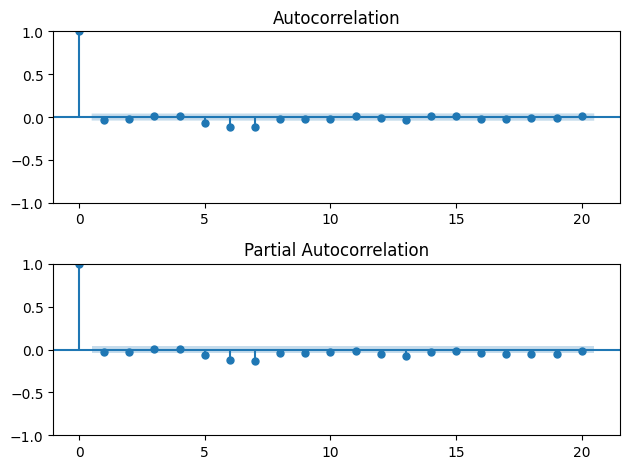

In [20]:
f, ax = plt.subplots(nrows=2, ncols=1)
plot_acf(df['Azerbaijan'].diff().dropna(),lags=20, ax=ax[0])
plot_pacf(df['Azerbaijan'].diff().dropna(),lags=20, ax=ax[1], method='ols')

# ax[0].annotate('Strong correlation at lag = 1', xy=(1, 0.5),  xycoords='data',
#             xytext=(0.15, 0.7), textcoords='axes fraction',
#             arrowprops=dict(color='red', shrink=0.05, width=1))

plt.tight_layout()
plt.show()

Given the ACF and PACF cut off after 1 lag, we have p=q=1 after first differencing d=1

## Azerbaijan ARIMA(1,1,1)

Mean Squared Error: 6.27845263524406


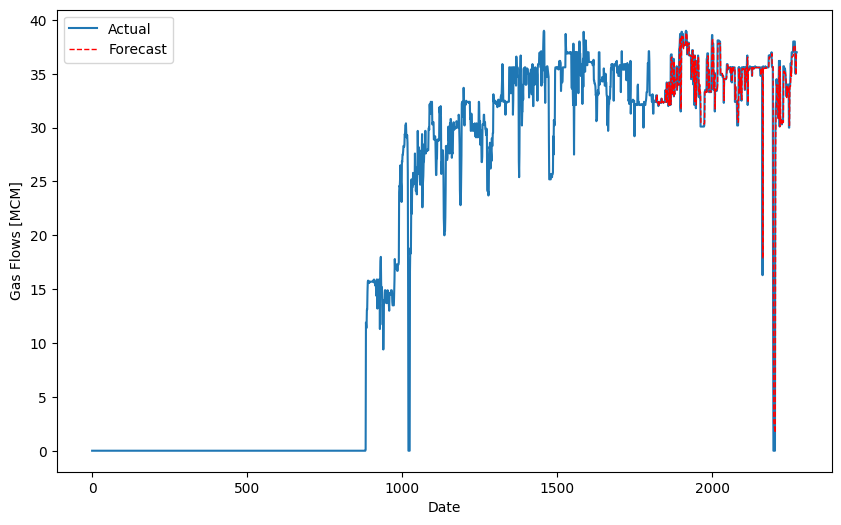

In [21]:
# Setting train and test data size at 80% and 20% respectively
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]
value= 'Azerbaijan'

# Fitting ARIMA model
predictions = []
history = [x for x in train[value]]

for t in range(len(test)):
    model = ARIMA(history, order=(1, 1, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[value].iloc[t]
    history.append(obs)

test['predictions'] = predictions

# Evaluating the model
mse = mean_squared_error(test[value], test['predictions'])
print(f'Mean Squared Error: {mse}')

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(df[value],label='Actual')
plt.plot(test['predictions'], label='Forecast', color='red', linestyle='--', linewidth=1)
plt.ylabel('Gas Flows [MCM]')
plt.xlabel('Date')
plt.legend()
plt.show()

In [22]:
print('The R^2 score for Azerbaijan flows time series is', r2_score(test['Azerbaijan'],test['predictions']))

The R^2 score for Azerbaijan flows time series is 0.7126243131185173


# Algeria Timeseries

## ADF test for Algeria

In [23]:
# Perform the ADF test
result = adfuller(df['Algeria'])

# Extract and print the test statistic and p-value
test_statistic = result[0]
p_value = result[1]

print(f'ADF Test Statistic: {test_statistic}')
print(f'p-value: {p_value}')

# Print the critical values
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Test Statistic: -2.889386319003792
p-value: 0.0465962184320905
Critical Value (1%): -3.4332609735287223
Critical Value (5%): -2.862825989564547
Critical Value (10%): -2.5674545927076724


### Given the timesteries are stationary (p>5%)

## ACF, PACF for Algeria

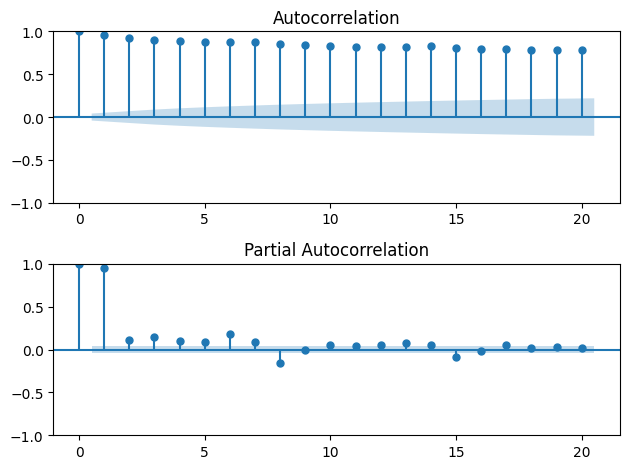

In [24]:
f, ax = plt.subplots(nrows=2, ncols=1)
plot_acf(df['Algeria'],lags=20, ax=ax[0])
plot_pacf(df['Algeria'],lags=20, ax=ax[1], method='ols')

plt.tight_layout()
plt.show()

Given the timeseries are stationary, the ACF does not cut off, and PACF cut off after 2 lags, we have p=2 q= 0 d=0

## Algeria ARIMA(2,0,0) so AR(2)

Mean Squared Error: 86.31082826309502


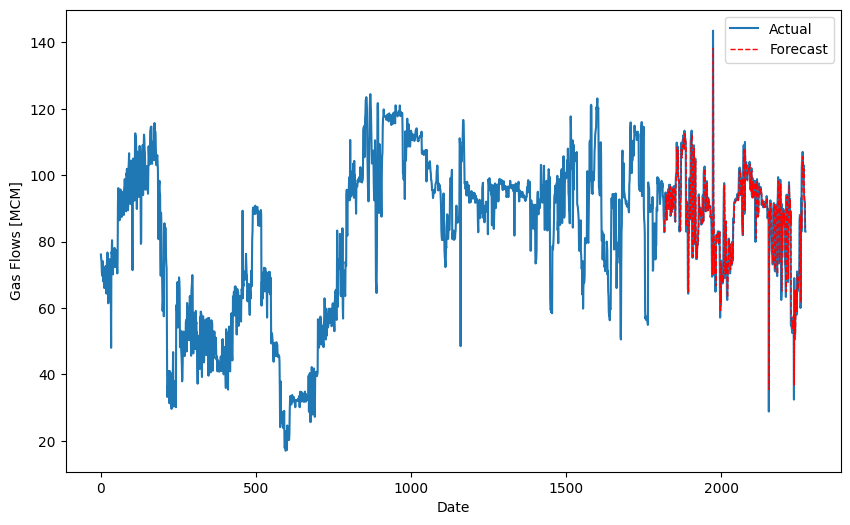

In [25]:
# Setting train and test data size at 80% and 20% respectively
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]
value= 'Algeria'


# Fitting ARIMA model
predictions = []
history = [x for x in train[value]]

for t in range(len(test)):
    model = ARIMA(history, order=(2, 0, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[value].iloc[t]
    history.append(obs)

test['predictions'] = predictions

# Evaluating the model
mse = mean_squared_error(test[value] , test['predictions'])
print(f'Mean Squared Error: {mse}')

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(df[value],label='Actual')
plt.plot(test['predictions'], label='Forecast', color='red', linestyle='--', linewidth=1)
plt.ylabel('Gas Flows [MCM]')
plt.xlabel('Date')
plt.legend()
plt.show()

In [26]:
print('The R^2 score for Algeria flows time series is', r2_score(test['Algeria'],test['predictions']))

The R^2 score for Algeria flows time series is 0.5427853522781545


# UK Timeseries

## ADF test for the United kingdom

In [27]:
# Perform the ADF test
result = adfuller(df['UK net flows'])

# Extract and print the test statistic and p-value
test_statistic = result[0]
p_value = result[1]

print(f'ADF Test Statistic: {test_statistic}')
print(f'p-value: {p_value}')

# Print the critical values
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Test Statistic: -3.596505612280023
p-value: 0.005828185427750458
Critical Value (1%): -3.4332442247528396
Critical Value (5%): -2.862818593996602
Critical Value (10%): -2.567450655093456


### Given the timesteries are stationary (p>5%)

## ACF, PACF for UK

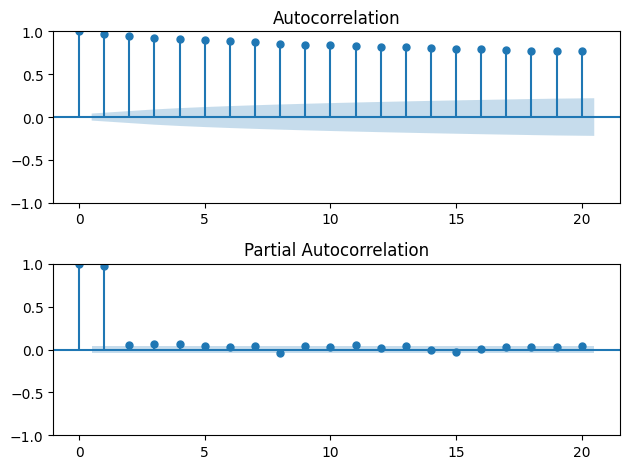

In [28]:
f, ax = plt.subplots(nrows=2, ncols=1)
plot_acf(df['UK net flows'],lags=20, ax=ax[0])
plot_pacf(df['UK net flows'],lags=20, ax=ax[1], method='ols')
plt.tight_layout()
plt.show()

Given the timeseries are stationary, the ACF does not cut off, and PACF cut off after 2 lags, we have p=2 q= 0 d=0

## UK ARIMA(2,0,0) so AR(2)

Mean Squared Error: 41.258583356050266


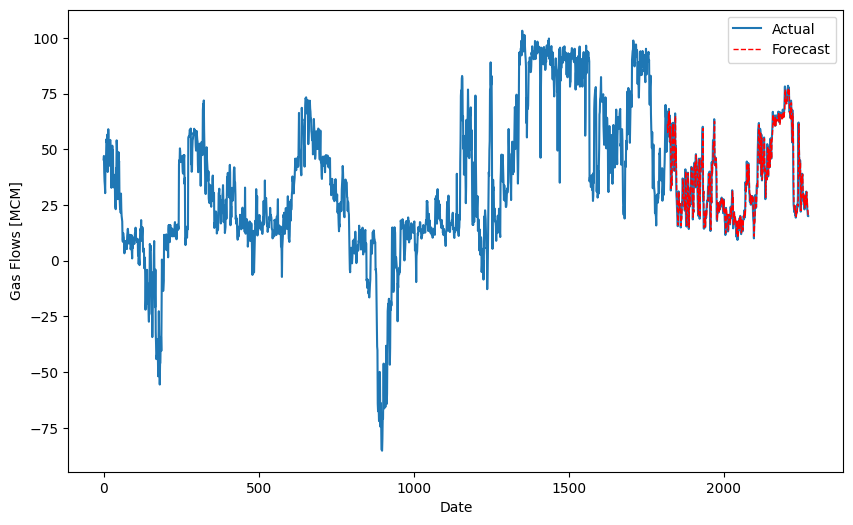

In [30]:
# Setting train and test data size at 80% and 20% respectively
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]
value= 'UK net flows'

# Fitting ARIMA model
predictions = []
history = [x for x in train[value]]

for t in range(len(test)):
    model = ARIMA(history, order=(2, 0, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[value].iloc[t]
    history.append(obs)

test['predictions'] = predictions

# Evaluating the model
mse = mean_squared_error(test[value], test['predictions'])
print(f'Mean Squared Error: {mse}')

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(df[value],label='Actual')
plt.plot(test['predictions'], label='Forecast', color='red', linestyle='--', linewidth=1)
plt.ylabel('Gas Flows [MCM]')
plt.xlabel('Date')
plt.legend()
plt.show()

In [31]:
print('The R^2 score for UK flows time series is', r2_score(test['UK net flows'],test['predictions']))

The R^2 score for UK flows time series is 0.8688493605816874


# Liquified Natural Gas Timeseries

## LNG Dickey Fueller Test

In [32]:
# Perform the ADF test
result = adfuller(df['LNG'])

# Extract and print the test statistic and p-value
test_statistic = result[0]
p_value = result[1]

print(f'ADF Test Statistic: {test_statistic}')
print(f'p-value: {p_value}')

# Print the critical values
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Test Statistic: -2.6488610977620755
p-value: 0.08331319238936863
Critical Value (1%): -3.4332661660670696
Critical Value (5%): -2.8628282823666926
Critical Value (10%): -2.567455813463227


### Given the timesteries are non stationary (p>5%), we perform ADF test after first differencing

In [33]:
# Perform the ADF test after first differencing
result = adfuller(df['LNG'].diff().dropna())

# Extract and print the test statistic and p-value
test_statistic = result[0]
p_value = result[1]

print(f'ADF Test Statistic: {test_statistic}')
print(f'p-value: {p_value}')

# Print the critical values
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Test Statistic: -9.90686388644515
p-value: 3.2461031854737406e-17
Critical Value (1%): -3.433267467097435
Critical Value (5%): -2.862828856845257
Critical Value (10%): -2.567456119332679


First differencing yielded stationary results (p value below 5%)

## ACF, PACF for LNG

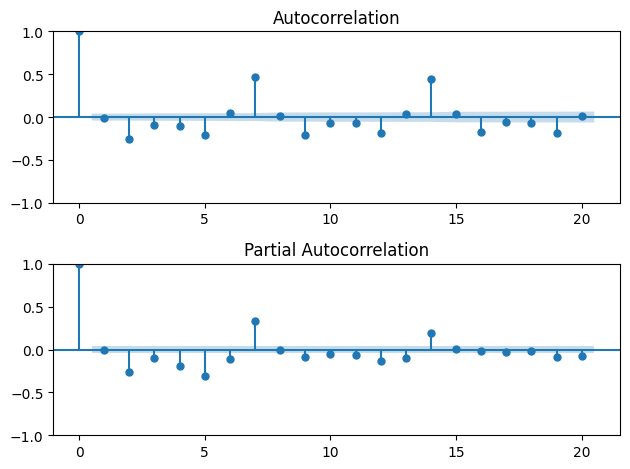

In [34]:
f, ax = plt.subplots(nrows=2, ncols=1)
plot_acf(df['LNG'].diff().dropna(),lags=20, ax=ax[0])
plot_pacf(df['LNG'].diff().dropna(),lags=20, ax=ax[1], method='ols')

# ax[0].annotate('Strong correlation at lag = 1', xy=(1, 0.5),  xycoords='data',
#             xytext=(0.15, 0.7), textcoords='axes fraction',
#             arrowprops=dict(color='red', shrink=0.05, width=1))

plt.tight_layout()
plt.show()

Given the ACF and PACF cut off after 1 lag, we have p=q=1 after first differencing d=1

## LNG ARIMA(1,1,1)

Mean Squared Error: 487.7651381004692


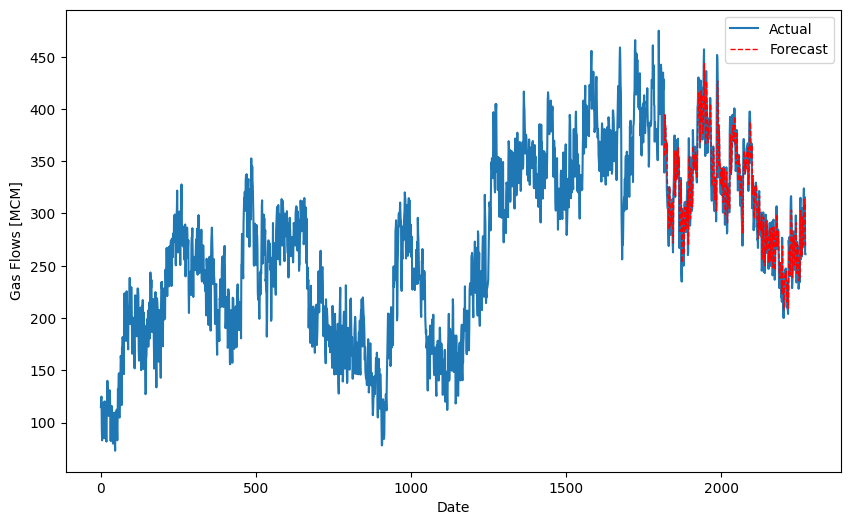

In [35]:
# Setting train and test data size at 80% and 20% respectively
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]
value= 'LNG'

# Fitting ARIMA model
predictions = []
history = [x for x in train[value]]

for t in range(len(test)):
    model = ARIMA(history, order=(1, 1, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[value].iloc[t]
    history.append(obs)

test['predictions'] = predictions

# Evaluating the model
mse = mean_squared_error(test[value], test['predictions'])
print(f'Mean Squared Error: {mse}')

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(df[value],label='Actual')
plt.plot(test['predictions'], label='Forecast', color='red', linestyle='--', linewidth=1)
plt.ylabel('Gas Flows [MCM]')
plt.xlabel('Date')
plt.legend()
plt.show()

In [36]:
print('The R^2 score for LNG flows time series is', r2_score(test['LNG'],test['predictions']))

The R^2 score for LNG flows time series is 0.8159885204021995


# EU total inflows Timeseries

## ADF test for the EU total

In [37]:
# Perform the ADF test
result = adfuller(df['EU total'])

# Extract and print the test statistic and p-value
test_statistic = result[0]
p_value = result[1]

print(f'ADF Test Statistic: {test_statistic}')
print(f'p-value: {p_value}')

# Print the critical values
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Test Statistic: -2.571691673731827
p-value: 0.09899029789790559
Critical Value (1%): -3.433258384187781
Critical Value (5%): -2.862824846221197
Critical Value (10%): -2.567453983958164


### Given the timesteries are non stationary (p>5%), we perform ADF test after first differencing

In [38]:
# Perform the ADF test after first differencing
result = adfuller(df['EU total'].diff().dropna())

# Extract and print the test statistic and p-value
test_statistic = result[0]
p_value = result[1]

print(f'ADF Test Statistic: {test_statistic}')
print(f'p-value: {p_value}')

# Print the critical values
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Test Statistic: -9.142619105592233
p-value: 2.822581786701779e-15
Critical Value (1%): -3.433267467097435
Critical Value (5%): -2.862828856845257
Critical Value (10%): -2.567456119332679


First differencing yielded stationary results (p value below 5%)

## ACF, PACF for EU total

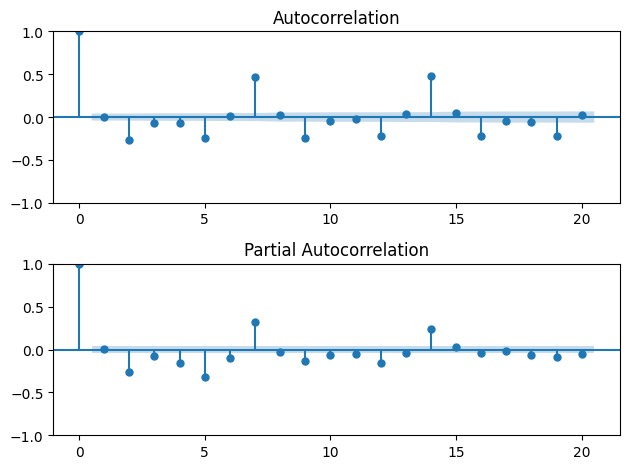

In [39]:
f, ax = plt.subplots(nrows=2, ncols=1)
plot_acf(df['EU total'].diff().dropna(),lags=20, ax=ax[0])
plot_pacf(df['EU total'].diff().dropna(),lags=20, ax=ax[1], method='ols')
plt.tight_layout()
plt.show()

Given the ACF and PACF cut off after 1 lag, we have p=q=1 after first differencing d=1

## EU ARIMA(1,1,1)

Mean Squared Error: 1071.4704557587197


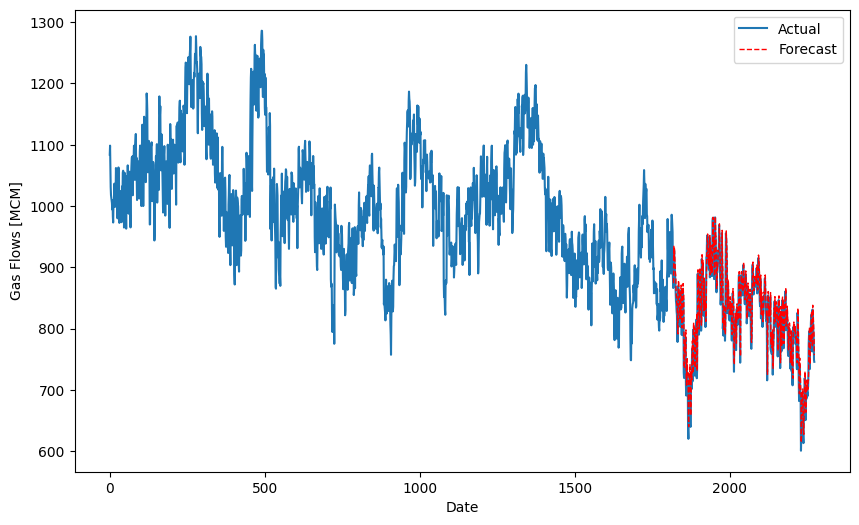

In [40]:
# Setting train and test data size at 80% and 20% respectively
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]
value= 'EU total'

# Fitting ARIMA model
predictions = []
history = [x for x in train[value]]

for t in range(len(test)):
    model = ARIMA(history, order=(2, 0, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[value].iloc[t]
    history.append(obs)

test['predictions'] = predictions

# Evaluating the model
mse = mean_squared_error(test[value], test['predictions'])
print(f'Mean Squared Error: {mse}')

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(df[value],label='Actual')
plt.plot(test['predictions'], label='Forecast', color='red', linestyle='--', linewidth=1)
plt.ylabel('Gas Flows [MCM]')
plt.xlabel('Date')
plt.legend()
plt.show()

In [41]:
print('The R^2 score for EU total inflows', r2_score(test['EU total'],test['predictions']))

The R^2 score for EU total inflows 0.7853396321512229
